In [17]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import json
import jax.numpy as np
import numpy as onp
import jax
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from timecast.learners import AR
from timecast.learners._ar import _ar_predict, _ar_batch_window
from timecast.utils.numpy import ecdf
from timecast.utils.losses import MeanSquareError
import torch
import matplotlib

plt.rcParams['figure.figsize'] = [20, 10]

import tqdm.notebook as tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from ealstm.gaip import FloodLSTM
from ealstm.gaip import FloodData
from ealstm.gaip.utils import MSE, NSE

from timecast.optim import SGD
from timecast.learners import AR

cfg_path = "/home/dsuo/src/toy_flood/ealstm/runs/run_2503_0429_seed283956/cfg.json"
flood_data = FloodData(cfg_path)
ea_data = pickle.load(open("../ealstm/runs/run_2503_0429_seed283956/lstm_seed283956.p", "rb"))

In [7]:
LR_AR = 1e-5
AR_INPUT_DIM=32
AR_OUTPUT_DIM=1

results = {}
mses = []
nses = []
sgd = SGD(learning_rate=LR_AR, online=False)
ar = AR(input_dim=AR_INPUT_DIM,
        output_dim=AR_OUTPUT_DIM,
        window_size=flood_data.cfg["seq_length"],
        optimizer=sgd,
        fit_intercept=True,
        constrain=False
       )
for X, _, basin in tqdm.tqdm(flood_data.generator(), total=len(flood_data.basins)):
    ar._history=X[:flood_data.cfg["seq_length"]]
    sgd = SGD(learning_rate=LR_AR, online=False)
    
    # NOTE: difference in indexing convention, so need to pad one row
    X = np.vstack((X[flood_data.cfg["seq_length"]:], np.ones((1, X.shape[1]))))
    Y = np.array(ea_data[basin].qobs).reshape(-1, 1)
    
    Y_lstm = np.array(ea_data[basin].qsim).reshape(-1, 1)
    Y_target = Y - Y_lstm
    
    Y_ar = ar.predict_and_update(X, Y_target)
    
    Y_hat = Y_lstm + Y_ar
    
    mse = MSE(Y, Y_hat)
    nse = NSE(Y, Y_hat)
    results[basin] = {
        "mse": mse,
        "nse": nse,
        "count": X.shape[0],
        "avg_mse": np.mean(np.array(mses)),
        "avg_nse": np.mean(np.array(nses))
    }
    mses.append(mse)
    nses.append(nse)
    print(basin, mse, nse, np.mean(np.array(mses)), np.mean(np.array(nses)))

01022500 0.59074104 0.8800156 0.59074104 0.8800156
01031500 1.0047275 0.8930459 0.79773426 0.88653076
01047000 1.4183334 0.8671004 1.0046006 0.880054
01052500 1.7531801 0.8661316 1.1917455 0.8765734
01054200 7.3232737 0.7515211 2.4180512 0.85156286
01055000 4.417208 0.7504427 2.7512438 0.83470947
01057000 0.92387015 0.87424976 2.4901905 0.84035814
01073000 0.89298964 0.8643622 2.2905405 0.84335864
01078000 0.6367511 0.89394206 2.106786 0.848979
01123000 0.8315705 0.83108246 1.9792645 0.8471893
01134500 1.7700413 0.78465766 1.960244 0.84150463
01137500 2.5338395 0.75082374 2.0080438 0.8339479
01139000 0.7516943 0.7889512 1.9114015 0.8304866
01139800 0.8577424 0.76479053 1.83614 0.82579404
01142500 1.0472485 0.7878938 1.7835473 0.82326734
01144000 0.6467383 0.86843634 1.7124968 0.82609046
01162500 0.8579534 0.831281 1.6622295 0.82639575
01169000 2.626449 0.7080909 1.7157973 0.81982327
01170100 2.023817 0.74962324 1.7320089 0.81612855
01181000 2.0169613 0.7800426 1.7462565 0.8143242
01187

02472500 1.7290754 0.7864624 1.9874451 0.72643715
02479155 6.340828 0.66231096 2.0135133 0.7260532
02479300 1.6861022 0.8029698 2.0115643 0.726511
02479560 1.1985029 0.86693573 2.0067532 0.72734195
02481000 7.30234 0.7058963 2.037904 0.7272158
02481510 2.3452055 0.8094244 2.039701 0.72769654
04015330 1.6280473 0.7555597 2.0373075 0.72785854
04024430 0.57219696 0.74624777 2.0288389 0.72796476
04027000 0.26425618 0.89017624 2.0186975 0.72889704
04040500 0.3417567 0.84276533 2.009115 0.72954774
04043050 1.2611823 0.7154335 2.0048654 0.7294676
04045500 0.035198364 0.9594233 1.9937373 0.7307668
04057510 0.03914269 0.94836646 1.9827565 0.7319892
04057800 0.47053906 0.7860398 1.9743083 0.7322911
04059500 0.11979846 0.8908809 1.9640056 0.7331722
04063700 0.11579796 0.82659334 1.9537944 0.73368835
04074950 0.055346135 0.7904927 1.9433634 0.7340005
04105700 0.03745329 0.77517307 1.9329484 0.7342254
04115265 0.10430537 0.6262598 1.9230101 0.7336387
04122200 0.036631625 0.8159789 1.9128135 0.73408

06906800 3.9774597 0.8044105 1.9735602 0.7070746
06910800 1.4080703 0.8593577 1.971857 0.7075333
06911900 1.800427 0.8464636 1.9713418 0.7079505
06917000 2.973448 0.74542785 1.9743422 0.7080627
06918460 1.0579194 0.8282883 1.9716066 0.7084216
06919500 1.1061301 0.8645308 1.9690309 0.7088862
06921070 1.8085251 0.8353884 1.9685546 0.70926154
06921200 5.5436163 0.6578428 1.9791317 0.7091094
07057500 0.87377584 0.7016195 1.975871 0.7090874
07060710 1.8854688 0.59199905 1.975605 0.708743
07066000 1.9025186 0.6118357 1.9753908 0.70845884
07083000 0.14680922 0.9679754 1.9700443 0.7092176
07142300 0.037439466 -0.59451795 1.9644097 0.7054166
07145700 1.4323832 0.7350418 1.9628631 0.7055027
07167500 10.805071 0.38915867 1.9884926 0.7045858
07180500 2.14659 0.6840194 1.9889494 0.70452636
07184000 8.918284 0.71023726 2.0089188 0.7045428
07195800 2.6631095 0.5799887 2.0107987 0.7041849
07196900 9.463246 0.5050286 2.0321524 0.7036142
07197000 1.3372432 0.8418132 2.0301669 0.70400906
07208500 0.04797

14305500 17.331936 0.85121626 2.6338506 0.68777245
14306340 8.896035 0.86336654 2.646425 0.688125
14306500 3.7076008 0.9080159 2.6485517 0.68856573
14308990 1.6033708 0.83068067 2.6464615 0.6888499
14309500 4.355601 0.8414824 2.6498725 0.68915457
14316700 4.501754 0.8372411 2.6535618 0.6894496
14325000 7.9736776 0.868306 2.6641383 0.6898052
14362250 0.27894285 0.7585693 2.659406 0.6899416
14400000 16.811792 0.9083636 2.6874304 0.69037414
10259000 0.41147533 0.37475652 2.6829324 0.6897504
11124500 2.3260865 0.09329516 2.6822286 0.688574
11141280 0.72363025 0.5511675 2.678373 0.68830353
11143000 3.375492 0.8725478 2.6797426 0.68866557
11148900 6.650004 0.7432746 2.6875274 0.68877256
11151300 0.38987625 -0.093568444 2.6830313 0.68724155
11176400 1.0200621 0.58153784 2.6797833 0.6870351
11230500 0.39926073 0.9518208 2.675338 0.68755126
11237500 2.3001082 0.8948018 2.6746078 0.6879544
11264500 0.8927596 0.9202538 2.6711483 0.6884055
11266500 1.0248901 0.91054606 2.6679575 0.688836
11284400 

In [8]:
def rolling_mean(x, n):
    return pd.Series(x).rolling(window=n, min_periods=1).mean()

In [24]:
batch_size_results = {}
for i in tqdm.tqdm([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]):
    with open("../tmp/batch_{}.pkl".format(i), "rb") as f:
        batch_size_results["batch_size={}".format(i)] = pickle.load(f)

In [25]:
rolling_means = {}
for i, batch_size_result in batch_size_results.items():
    rolling_means[i] = rolling_mean([result["mse"].item() for result in batch_size_result.values()], 531)

In [26]:
rolling_means = pd.DataFrame.from_dict(rolling_means)

In [27]:
rolling_means["single_ar"] = rolling_mean(mses, 5311)

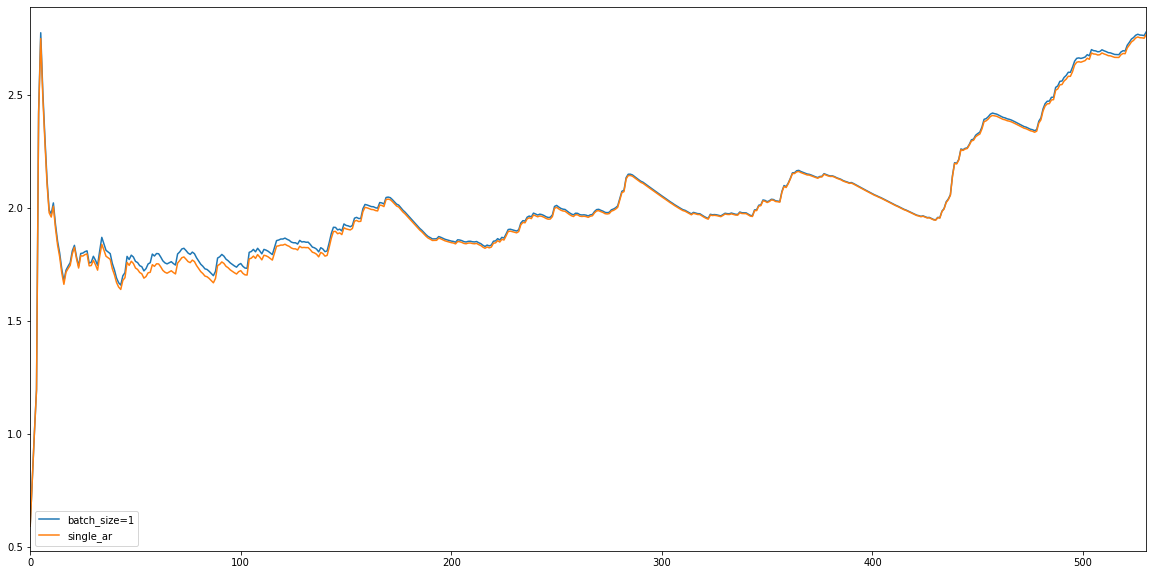

In [28]:
rolling_means[["batch_size=1", "single_ar"]].plot()